In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
%matplotlib notebook
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None


In [ ]:
NUM_MELHORES = 40

In [ ]:
df_melhores = pd.read_feather('dados/melhores.feather')
df_turmas = pd.read_feather('dados/turmas2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')

In [31]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')

## Nota final
Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas. 

Algumas universidades consideram um peso distinto de acordo com a disciplina

### Pesos UFRJ

Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

- Redação: peso 3 (mínimo 300)
- Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
    - Matemática tem peso 4
- Ciências Econômicas, Geologia e Meteorologia
    - Matemática peso 3
- Engenharias e Química Industrial
    - Ciências da Natureza: peso 4
- Geologia
    - Ciências da Natureza: peso 3
- Humanas
    - Ciências Humanas e Linguagens: peso 2



In [27]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4)


In [38]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

df_enem_rio['nota_final'] = df_enem_rio\
  .loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]\
  .apply(media_ponderada, axis=1).round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,431.7,560.9,479.7,557.0,560.0,534.0
3,590.7,487.7,527.6,492.7,600.0,562.0
4,530.7,669.8,626.8,638.1,740.0,678.0


In [44]:
notas_agg = {col: (col, 'median') for col in notas_cols}
notas_agg['mediana'] = ('nota_final', 'median')
notas_agg['num'] = ('nota_final', 'count')

df_melhores = df_enem_rio.groupby('CO_ESCOLA')\
       .agg(**notas_agg).sort_values('mediana', ascending=False)
df_melhores = df_melhores[df_melhores.num > 30] #corte arbitrário, só quem tem mais de 30 alunos
df_melhores.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33135371,662.7,691.40,635.00,763.2,920.0,803.0,91
33062633,689.5,702.85,645.70,801.1,900.0,800.5,62
33063729,653.3,692.05,628.35,766.7,900.0,789.0,245
33176825,654.4,691.10,637.60,771.8,900.0,788.0,185
33148376,615.2,679.80,617.75,747.7,900.0,780.0,73


In [6]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837

In [46]:
df_melhores['CO_ESCOLA'] = df_melhores.index.astype('category')
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False, method='min')

In [47]:
df_melhores = df_melhores.merge(df_escolas, left_index=True, right_on='CO_ENTIDADE').loc[:,
    ['NO_ENTIDADE',  'mediana', 'num', 'rank'] + notas_cols + ['CO_ENTIDADE']]
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376
175263,COLEGIO SANTO AGOSTINHO,780.0,135,5.0,658.30,699.10,648.30,762.60,880.0,33065403
188370,ESC MODELAR CAMBAUBA,779.0,45,7.0,639.40,682.40,626.90,736.40,900.0,33085897
194555,COLEGIO DE A A Z - UNIDADE TIJUCA,777.0,63,8.0,621.00,681.10,635.90,734.10,860.0,33173990
191289,COLEGIO E CURSO PENSI,776.0,94,9.0,651.25,687.55,623.85,759.00,880.0,33135827
190474,RECANTO INF IMACULADA CONCEICAO,776.0,68,9.0,653.90,681.20,634.70,751.05,880.0,33104220


In [11]:

df_enem = df_melhores.head(NUM_MELHORES).merge(df_enem_rio, 
                                     left_on='CO_ENTIDADE', right_on='CO_ESCOLA')\
          #.loc[:,list(notas_agg.keys()) + ['CO_ESCOLA']]
df_enem.head()

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN_x,NU_NOTA_CH_x,NU_NOTA_LC_x,NU_NOTA_MT_x,NU_NOTA_REDACAO_x,CO_ENTIDADE,index,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN_y,NU_NOTA_CH_y,NU_NOTA_LC_y,NU_NOTA_MT_y,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO_y,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,nota_final
0,COL DE SAO BENTO,785.0,62,1.0,689.5,702.85,645.7,801.1,900.0,33062633,283991,180009272587,2018,3304557,Rio de Janeiro,33,RJ,18.0,M,0.0,1,1,3304557.0,Rio de Janeiro,33.0,RJ,2,0,4,1.0,0,33062633,3304557.0,Rio de Janeiro,33.0,RJ,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3304557,Rio de Janeiro,33,RJ,1.0,1.0,1.0,1.0,449.0,452.0,456.0,462.0,644.5,671.0,647.2,745.6,BCAECABBADDDDCBACECBDCDEBBADBBCEAAAAAEADBCADE,AEECAECEAABCECDEDEEDBDAEBBAABCCAABEDAEABBEECC,BBDDC99999BBEADECABEDCECDABACBCBAEABDDABDDBADB...,DCBABCDDABDECBDDACBACEEDECADDEEDBECBEADAABADE,0,EBBEBACEDDEDDCBCCACBDDDAECAADBCEABEAEABDBCACE,AEECDECBEBDCACDEDEEDBDDEBCECDECAABEDBEBBEBECC,BBEDCCBBDBBBEADECACEDBEADABEDBABAECCBEABDDBACD...,ADCACEDDABEBBCBCADDACCCDEBBDAEEDBEXBCAEDABADA,1.0,180.0,200.0,160.0,180.0,200.0,920.0,F,F,D,D,2,H,B,B,C,B,A,B,B,B,A,B,A,A,C,A,B,B,B,B,B,B,D,781.0
1,COL DE SAO BENTO,785.0,62,1.0,689.5,702.85,645.7,801.1,900.0,33062633,397048,180009241863,2018,3304557,Rio de Janeiro,33,RJ,17.0,M,0.0,1,4,NaN,None,NaN,None,2,0,4,1.0,0,33062633,3304557.0,Rio de Janeiro,33.0,RJ,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3304557,Rio de Janeiro,33,RJ,1.0,1.0,1.0,1.0,448.0,451.0,455.0,460.0,727.3,710.6,678.3,785.8,BCACEEBABDACEDECBADDBEBDBCCECDBACECEDABEAEDBE,CACDDBDDECCEDDEEBEEAEEDBBBBECAEDCABEBDCAEBCDE,BBDEC99999CECBDBDBEDABBDDBBEADECAAEDBECCBBDEAE...,ADDEBCABEAADBEAEBCDEEDCBCDCDACDDDACDBBEAEBBEC,0,BCACEEBBBDACEDECAADDDABDBCCACDCBCEDEDABEBEAEA,CACDDBDDECCEDEEEBCEAEECBBEBEDBEDECBEBDCAABCDE,BBDECBBCDBCECBABDBEDACDDBBBEADECACEDBEBABCBEAE...,ADAEDABBCAADBEXEBBDEEADCCCCDACEDDABCBCAAEBBDD,1.0,160.0,200.0,200.0,200.0,200.0,960.0,G,F,E,D,4,M,B,C,C,B,A,B,B,B,A,B,A,B,C,B,B,E,A,E,B,B,E,826.0
2,COL DE SAO BENTO,785.0,62,1.0,689.5,702.85,645.7,801.1,900.0,33062633,405940,180008539890,2018,3304557,Rio de Janeiro,33,RJ,17.0,M,0.0,1,1,3304557.0,Rio de Janeiro,33.0,RJ,2,0,4,1.0,0,33062633,3304557

In [12]:
my_order = df_melhores.head(NUM_MELHORES).NO_ENTIDADE

(40,)

Ajustar no gráfico abaixo:

- nomes escolas -> santo agostinho barra, ph iguais, tudo maiúculo


In [13]:
df_melhores['rotulo'] = df_melhores.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)

In [43]:
df_melhores.head()

,CO_ESCOLA,mediana,num
0,33135371,920.0,92
1,33176825,900.0,185
2,33173869,900.0,77
3,33148376,900.0,74
4,33063729,900.0,253


In [42]:
NOTA = 'nota_final'

sns.set(rc={'figure.figsize':(11,18), 'axes.xmargin': .1})

df_top = df_melhores.sort_values(NOTA).head(NUM_MELHORES)
ax = sns.boxplot(data=df_enem, y='CO_ESCOLA', x=NOTA, orient='h', 
                 order=df_top.CO_ENTIDADE)
ax.set(ylabel='', xlabel='')
plt.suptitle('Notas finais (ponderadas) por escola', x=0,  size=24);
locs, _ = plt.yticks()
plt.yticks(locs, df_top.rotulo);


KeyError: 'nota_final'

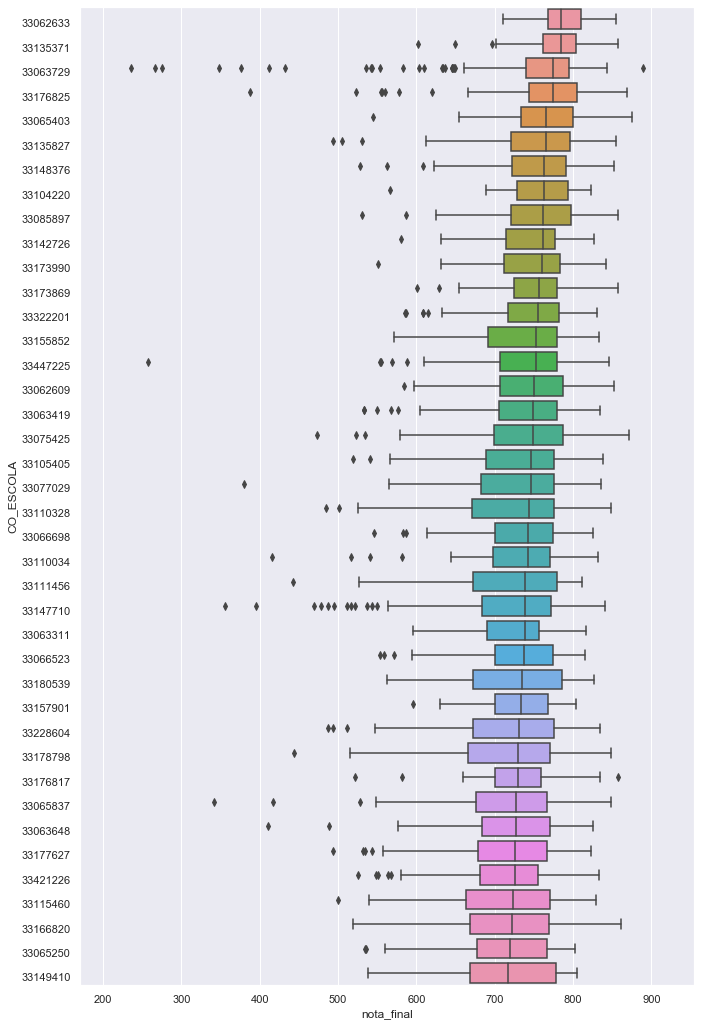

In [17]:
import seaborn as sns
sns.set()
ax = sns.boxplot(data=df_enem, y='CO_ESCOLA', x='NU_NOTA_MT', orient='h', 
                 order=df_melhores.head(NUM_MELHORES).CO_ENTIDADE)
locs, labels = plt.yticks()
plt.yticks(locs, labels);




In [39]:
sns.boxplot(data=df_enem_rio, y='NO_ENTIDADE', x='NU_NOTA_REDACAO', orient='h', 
            order=df_melhores.sort_values('rank')['NO_ENTIDADE'].head(NUM_MELHORES));

KeyError: 'rank'

In [ ]:
df_escolas.columns.tolist()